In [144]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

In [2]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [3]:
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "data",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
data, dataloader = load_transformed_fashionMNIST(16, batch_size)

### Forward Diffusion

Here we are incrementally adding noise to the image starting with very little to all the way up to creating complete junk.
We start with an initial image sampled from the true distribution $x_0$~$q(x)$, then we create random noise tensor sampled from $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ which follows a normal distribution.
Multilpy this noise with $\sqrt{\beta_{t}}$, where $\beta_{t}$ is the variance scheduler tensor at time step $t$, initially it is very low. This is what decides the amount of noise added.
Add this product to the another product (std. coefficient) created from image at previous time using $\sqrt{1-\beta_{t}} * x_t$

This whole process is follows Markov Chain, where the current output depends only on the previous output.

$\mathbf{x}_{t}$   :- image at timestep $t$

$\mathbf{x}_{t-1}$ :- image at the previous timestep 

$x_{0}$            :- original image.


We will alter images with the similar equation:

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};\sqrt{1-\beta_{t}} \cdot \mathbf{x}_{t-1},\beta_{t} \cdot \mathbf{I})$

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ describes the probability distribution for a new, noiser image $\mathbf{x}_{t}$ based on $\mathbf{x}_{t-1}$.

In [23]:
# Variational Scheduler = betaT_steps
nrows = 10
ncols = 15

time_steps = nrows * ncols
start = 0.0001
end = 0.02
beta = torch.linspace(start, end, time_steps).to(device)

alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # Mean Coefficient
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar) # St. Dev. Coefficient

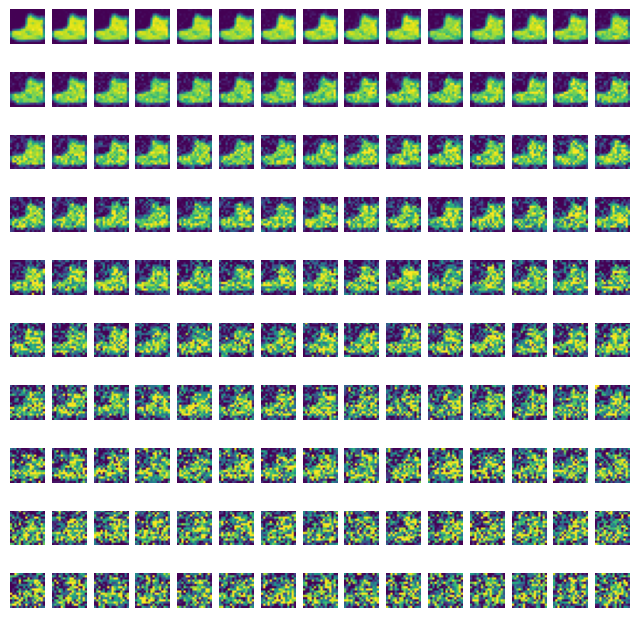

In [24]:
def q(x_0, t):
    """
    q(X_t|X_t-1)
    Samples a new image from distribution q~N(sqrt(1-beta_t) * x_t-1, beta_t)
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[t, None, None, None]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t, None, None, None]

    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

plt.figure(figsize=(8, 8))
x_0 = data[0][0]
xs = []

for t in range(time_steps):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    show_tensor_image(x_t)
plt.savefig("images\\forward_diffusion_skip.png", bbox_inches='tight')

In [31]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        inputs = input.view(-1, self.input_dim)
        return self.model(inputs)

In [59]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, stride=1, padding=1):
        super(DownBlock, self).__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),   
            nn.MaxPool2d(2)
        ]

        self.net = nn.Sequential(*layers)
        
    def forward(self, X):
        return self.net(X)

In [137]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, stride=1, padding=1, strideT=2, outer_paddingT=1):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2*in_ch, out_ch, kernel, strideT, padding, outer_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, X, skip):
        X = torch.cat((X, skip), 1)
        return self.net(X)

In [138]:
class UNet(nn.Module):
    def __init__(self, in_chs=1, img_size=16, kernel=3, stride=1, padding=1):
        super(UNet, self).__init__()
        down_chs = [16, 32, 64]
        up_chs = [64, 32, 16]
        t_dim = 1

        image_size_after_downblock = img_size // (2 ** (len(down_chs) - 1))

        # Down Block
        self.down0 = nn.Sequential(
            nn.Conv2d(in_chs, down_chs[0], kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )
        
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*image_size_after_downblock**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*image_size_after_downblock**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])

        # Up Block
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], image_size_after_downblock, image_size_after_downblock)),
            nn.Conv2d(up_chs[0], up_chs[0], kernel, padding=padding),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU()
        )

        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match ouput channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[2], up_chs[2], kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(up_chs[2]),
            nn.ReLU(),
            nn.Conv2d(up_chs[2], in_chs, kernel, stride, padding)
        )
        
        
    def forward(self, X, t):
        down0 = self.down0(X)
        down1 = self.down1(down0)
        down2 = self.down2(down1)

        latent_vec = self.to_vec(down2)
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / time_steps  # Convert from [0, T] to [0, 1]
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [139]:
model = UNet()

In [69]:
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)

### Reverse Diffusion

If we can reverse the above process and sample from $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$, we will be able to recreate the true sample from a Gaussian noise input, $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. Note that if $\beta_t$ is small enough, $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$ will also be Gaussian. Unfortunately, we cannot easily estimate $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$ because it needs to use the entire dataset and therefore we need to learn a model $p_\theta$ to approximate these conditional probabilities in order to run the **reverse diffusion process**.

$
p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t=1}^T p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) \quad$

$p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_t, t), \Sigma_\theta(\mathbf{x}_t, t))
$

It is noteworthy that the reverse conditional probability is tractable when conditioned on $x_0$:

$
q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{X}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \cdot \mathbf{I})
$

$
\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \alpha_t}} \cdot \epsilon_t \right)
$ 

$\epsilon_t$ is the noise added at time $t$. This is what the neural network will estimate.

A path which leads us to get the above mean value can be found here [Lilian Weng's Blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#speed-up-diffusion-model-sampling).

In [152]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    """
    p(X_t-1|X_t)
    """
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        beta_t = beta[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(beta_t) * new_noise

In [155]:
@torch.no_grad()
def plot_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = time_steps / ncols
    img_ch = 1
    img_size = 16

    # Noise to generate images from
    x_t = torch.randn((1, img_ch, img_size, img_size), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, time_steps)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

Epoch 0 | Step 000 | Loss: 0.977958083152771 


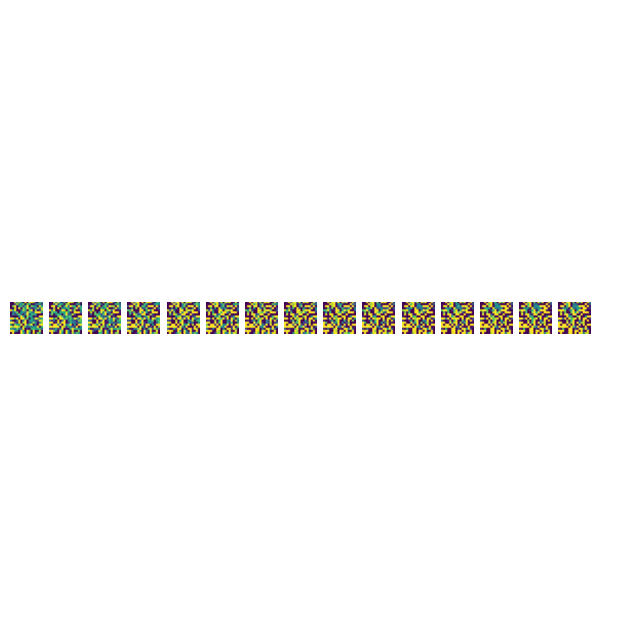

Epoch 0 | Step 100 | Loss: 0.3750772476196289 


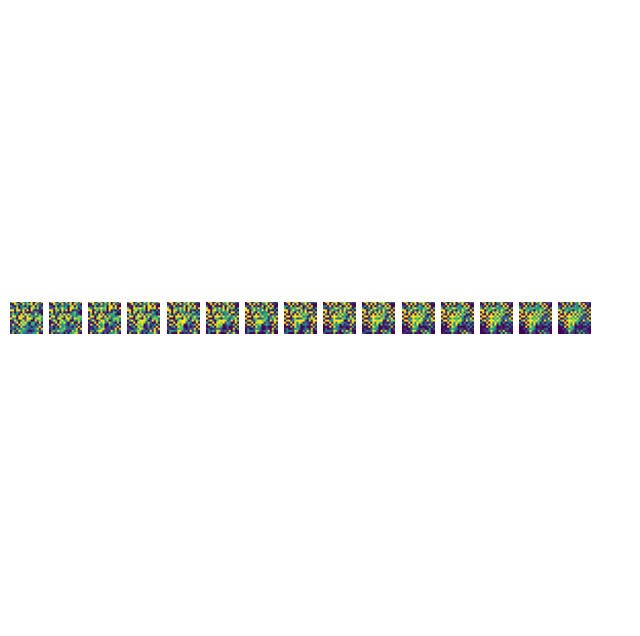

Epoch 0 | Step 200 | Loss: 0.29966217279434204 


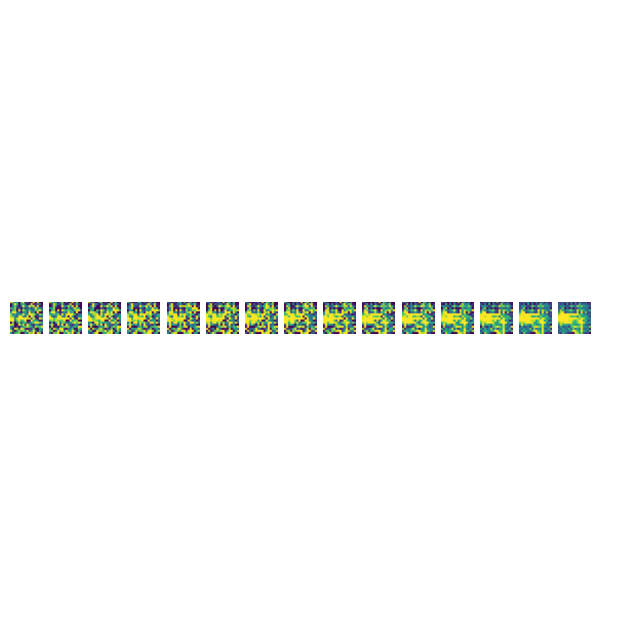

Epoch 0 | Step 300 | Loss: 0.2636626064777374 


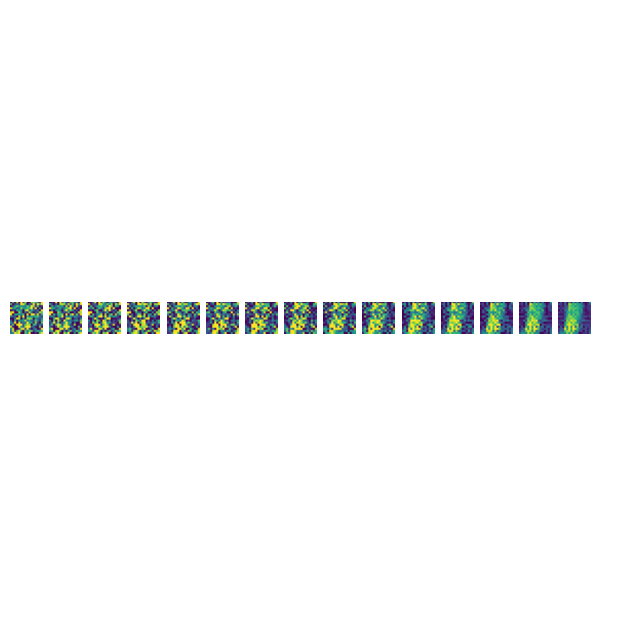

Epoch 0 | Step 400 | Loss: 0.2154645025730133 


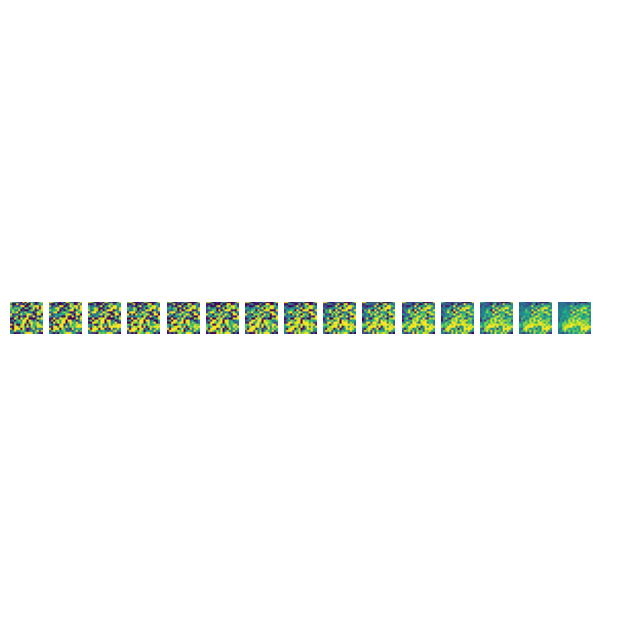

Epoch 0 | Step 500 | Loss: 0.23242279887199402 


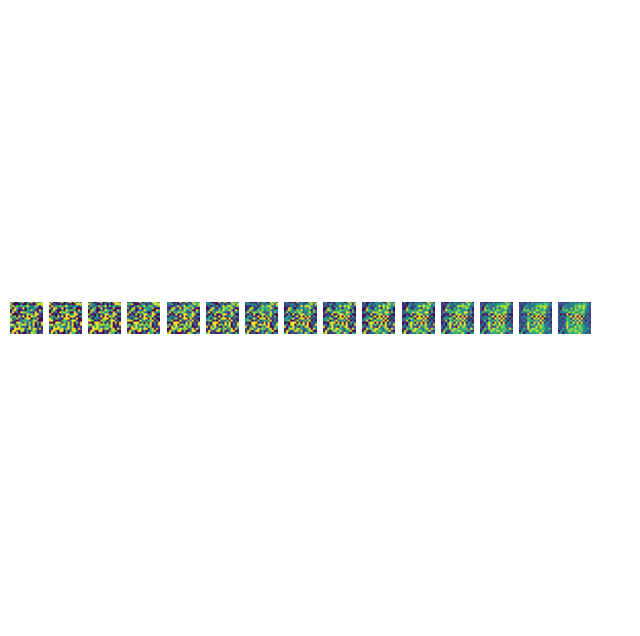

Final sample:


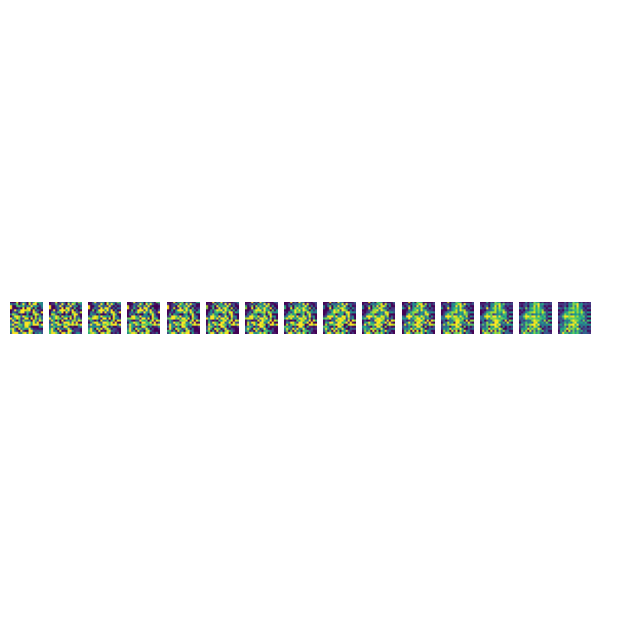

In [156]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 1
ncols = 15  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, time_steps, (batch_size,), device=device)
        x = batch[0].to(device)
        x_noisy, noise = q(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch+1} | Step {step:03d} | Loss: {loss.item()} ")
            plot_images(ncols)
print("Final sample:")
plot_images(ncols)